In [4]:
import os
import pandas as pd
from radon.metrics import mi_visit
from radon.complexity import cc_visit
from radon.visitors import HalsteadVisitor
from radon.metrics import h_visit_ast, halstead_visitor_report
from radon.raw import analyze
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def analyze_py_file(file_path):
    """Analyzes a Python file and returns metrics."""
    with open(file_path, 'r', encoding='utf-8') as f:
        code = f.read()

    # Basic metrics (LOC, comments)
    raw_metrics = analyze(code)
    
    # Maintainability Index
    mi = mi_visit(code, multi=True)
    
    # Cyclomatic Complexity
    cc_results = cc_visit(code)
    cc_total = sum([block.complexity for block in cc_results])
    cc_average = cc_total / len(cc_results) if cc_results else 0
    
    # Halstead Metrics
    visitor = HalsteadVisitor.from_code(code)
    report = halstead_visitor_report(visitor)

    return {
        'File': os.path.basename(file_path),
        'Path': file_path,
        'LOC': raw_metrics.loc,
        'Comments': raw_metrics.comments,
        'MI': mi,
        'CC_Total': cc_total,
        'CC_Average': cc_average,
        'Halstead_values': report,
    }

def analyze_directory(directory, excluded_dirs=[]):
    """Traverses a directory and analyzes all .py files, excluding specified directories completely.
    Args:
        directory: Root directory to analyze
        excluded_dirs: List of directory names to exclude (e.g., ['test', 'venv'])
    """
    data = []
    for root, dirs, files in os.walk(directory):
        # Remove excluded directories from dirs to prevent walking into them
        dirs[:] = [d for d in dirs if d not in excluded_dirs]
        
        for file in files:
            if file.endswith('.py'):
                path = os.path.join(root, file)
                
                # Check if any of the excluded dirs is in the file's path
                if any(excluded_dir in path.split(os.sep) for excluded_dir in excluded_dirs):
                    continue  # Skip files in excluded directories
                
                try:
                    metrics = analyze_py_file(path)
                    data.append(metrics)
                except Exception as e:
                    print(f"Error analyzing {path}: {e}")
    
    # Create DataFrame from collected data
    df = pd.DataFrame(data)
    
    # Calculate averages for numeric columns only
    if not df.empty:
        numeric_cols = df.select_dtypes(include=['number']).columns
        averages = df[numeric_cols].mean().to_dict()
        
        # Create averages row with same structure
        averages_row = {
            'File': 'AVERAGE',
            'Path': 'ALL FILES',
            **averages
        }
        
        # Append averages to DataFrame
        df = pd.concat([df, pd.DataFrame([averages_row])], ignore_index=True)
    
    return df

In [12]:
# Replace with the path to your repository
file_path = "../original/requests/src/requests"
excluded_dirs = ["__pycache__", ".git", "tests", "testing"]
data = analyze_directory(file_path, excluded_dirs)

# Display the first rows
display(data)

data.to_csv("./metrics/requests_original_metrics.csv", index=False)

,File,Path,LOC,Comments,MI,CC_Total,CC_Average,Halstead_values
0,hooks.py,../original/requests/src/requests/hooks.py,33.000000,1.000000,93.000817,8.000000,4.000000,"(2, 4, 2, 4, 6, 6, 10.0, 15.509775004326936, 1..."
1,sessions.py,../original/requests/src/requests/sessions.py,831.000000,120.000000,38.091624,122.000000,4.066667,"(12, 109, 68, 133, 121, 201, 780.7516414093388..."
2,api.py,../original/requests/src/requests/api.py,157.000000,3.000000,100.000000,8.000000,1.000000,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0)"
3,cookies.py,../original/requests/src/requests/cookies.py,561.000000,13.000000,39.757481,126.000000,2.377358,"(11, 75, 52, 102, 86, 154, 505.2151495922013, ..."
4,status_codes.py,../original/requests/src/requests/status_codes.py,128.000000,5.000000,84.220652,6.000000,6.000000,"(4, 8, 5, 9, 12, 14, 32.0, 50.18947501009619, ..."
5,models.py,../original/requests/src/requests/models.py,1039.000000,122.000000,21.690866,214.000000,4.458333,"(14, 142, 93, 164, 156, 257, 1068.567059878471..."
6,exceptions.py,../original/requests/src/requests/exceptions.py,151.000000,1.000000,77.249881,36.000000,1.285714,"(3, 6, 3, 6, 9, 9, 20.264662506490406, 28.5293..."
7,certs.py,../original/requests/src/requests/certs.py,17.000000,1.000000,64.359598,0.000000,0.000000,"(1, 2, 1, 2, 3, 3, 2.0, 4.754887502163469, 0.5..."
8,_internal_utils.py,../original/requests/src/requests/_internal_ut...,50.000000,0.000000,100.000000,5.000000,2.500000,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0)"
9,compat.py,../original/requests/src/requests/compat.py,106.000000,19.000000,80.404969,4.000000,4.000000,"(2, 8, 4, 8, 10, 12, 26.0, 39.863137138648355,..."


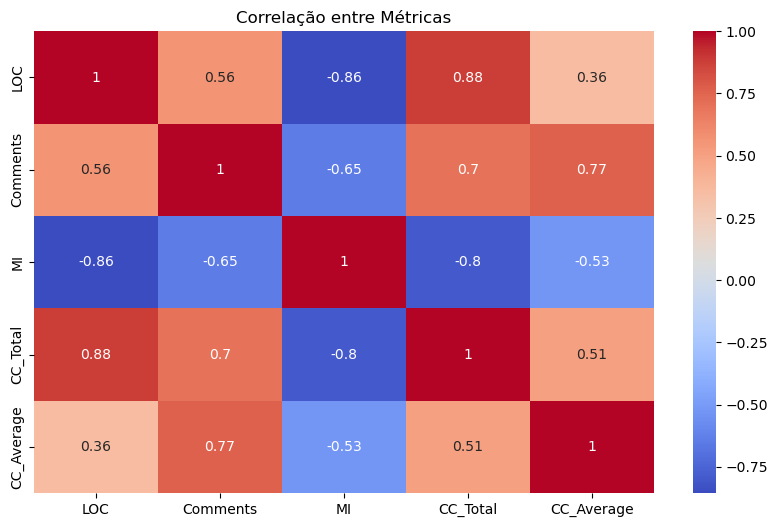

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlação entre Métricas")
plt.show()

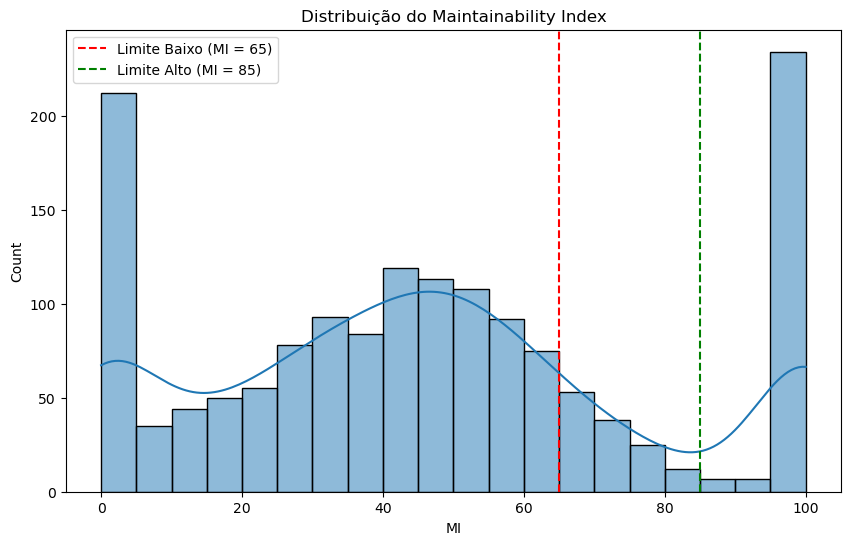

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data['MI'], bins=20, kde=True)
plt.axvline(65, color='red', linestyle='--', label='Limite Baixo (MI = 65)')
plt.axvline(85, color='green', linestyle='--', label='Limite Alto (MI = 85)')
plt.title("Distribuição do Maintainability Index")
plt.legend()
plt.show()

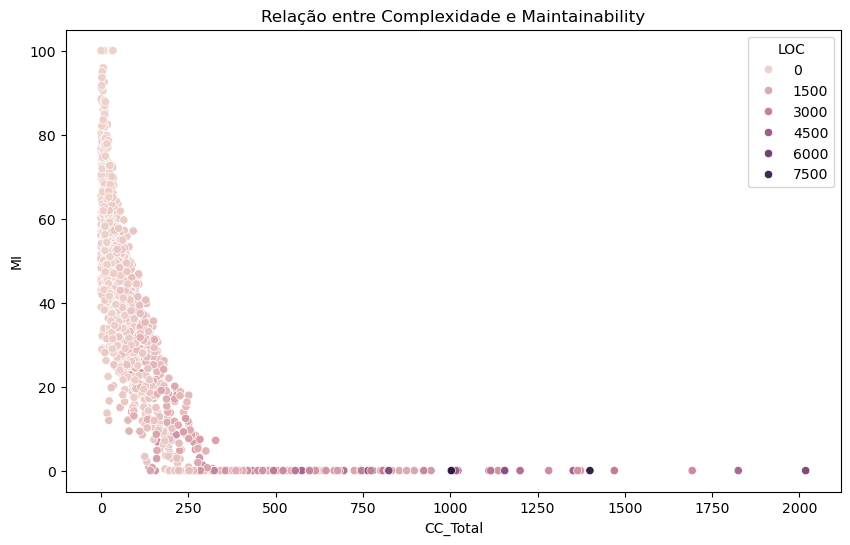

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='CC_Total', y='MI', hue='LOC', sizes=(20, 200))
plt.title("Relação entre Complexidade e Maintainability")
plt.show()